### This analysis is based on the pull aligned continuous bhv variables and neural activity analysis
### The goal of this code is to define GLM model and test the hypothesis that social gaze before pull serves as a evidence accumulation process, and test if the neural profile matches the accumulation hypothesis
### note, the glm will be used to fit the behavioral data only, so it's different from the neuralGLM code

In [1]:
import numpy as np
import pandas as pd # Added import for Pandas

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
import scipy.io
from scipy.stats import pearsonr

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from dPCA import dPCA

import string
import warnings
import pickle
import json

from scipy.ndimage import gaussian_filter1d

import sys
import os
import glob
import random
from time import time


In [2]:
# to be able to use the functions in the ana_functions under /3d_recontruction_analysis_self_and_coop_task_neural_analysis/
sys.path.append(os.path.abspath('../3d_recontruction_analysis_self_and_coop_task_neural_analysis/'))

### function - get body part location for each pair of cameras

In [3]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [4]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [5]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [6]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody_2 import find_socialgaze_timepoint_singlecam_wholebody_2


### function - define time point of behavioral events

In [7]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [8]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.plot_continuous_bhv_var_singlecam import plot_continuous_bhv_var_singlecam
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [9]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [10]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo
from ana_functions.tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo

### function - interval between all behavioral events

In [11]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [12]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR import plot_bhv_events_aligned_FR
from ana_functions.plot_strategy_aligned_FR import plot_strategy_aligned_FR

### function - PCA projection

In [13]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

### function - other useful functions

In [14]:
# for defining the meaningful social gaze (the continuous gaze distribution that is closest to the pull) 
from ana_functions.keep_closest_cluster_single_trial import keep_closest_cluster_single_trial

In [15]:
# get more information for each pull: number of preceding failed pull and time since last reward/successful pull
from ana_functions.get_pull_infos import get_pull_infos


In [16]:
from functions.continuous_variable_glm import continuous_variable_glm
from functions.continuous_variable_glm_shortlist_prediction import continuous_variable_glm_shortlist_prediction
from functions.continuous_variable_create_data_forGLM import continuous_variable_create_data_forGLM

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [33]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    # '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                    '20250422_Dodson_MC_withKanga',
                                    '20250422_Dodson_SR_withKanga',
            
                                    '20250423_Dodson_MC_withKanga',
                                    '20250423_Dodson_SR_withKanga', 
                                    '20250424_Dodson_NV_withKanga',
                                    '20250424_Dodson_MC_withKanga',
                                    '20250424_Dodson_SR_withKanga',            
                                    '20250425_Dodson_NV_withKanga',
                                    '20250425_Dodson_SR_withKanga',
                                    '20250428_Dodson_NV_withKanga',
                                    '20250428_Dodson_MC_withKanga',
                                    '20250428_Dodson_SR_withKanga',  
                                    '20250429_Dodson_NV_withKanga',
                                    '20250429_Dodson_MC_withKanga',
                                    '20250429_Dodson_SR_withKanga',  
                                    '20250430_Dodson_NV_withKanga',
                                    '20250430_Dodson_MC_withKanga',
                                    '20250430_Dodson_SR_withKanga',  
            
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            # 'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga', 
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',            
                            'NV_withKanga',
                            'SR_withKanga',
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        # '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                        '20250422',
                        '20250422_SR',
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            # '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
                            '20250422',
                            '20250422_SR',
            
                            '20250423',
                            '20250423_SR', 
                            '20250424',
                            '20250424_MC',
                            '20250424_SR',            
                            '20250425',
                            '20250425_SR',
                            '20250428_NV',
                            '20250428_MC',
                            '20250428_SR',  
                            '20250429_NV',
                            '20250429_MC',
                            '20250429_SR',  
                            '20250430_NV',
                            '20250430_MC',
                            '20250430_SR',  
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                # 0.00,
                                79.0,
                                162.6,
                                231.9,
                                109,
                                0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
            
                              ] # in second
        
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0',# 'Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson',# 'dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', # 'kanga', 
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             'Dodson',# 'Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                             'Kanga', # 'Kanga', 
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     '20231101_Dodson_withGinger_SR',
                                     '20231107_Dodson_withGinger_SR',
                                     '20231122_Dodson_withGinger_SR',
                                     '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            'SR',
                            'SR',
                            'SR',
                            'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      "20231101_SR",
                      "20231107_SR",
                      "20231122_SR",
                      "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         2, 
                         2, 
                         4, 
                         4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorder = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorder = ['ginger']*np.shape(dates_list)[0]

        animal1_filename = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filename = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 0:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                     '20250422_Kanga_MC_withDodson',
                                     '20250422_Kanga_SR_withDodson',
            
                                    '20250423_Kanga_MC_withDodson',
                                    '20250423_Kanga_SR_withDodson', 
                                    '20250424_Kanga_NV_withDodson',
                                    '20250424_Kanga_MC_withDodson',
                                    '20250424_Kanga_SR_withDodson',            
                                    '20250425_Kanga_NV_withDodson',
                                    '20250425_Kanga_SR_withDodson',
                                    '20250428_Kanga_NV_withDodson',
                                    '20250428_Kanga_MC_withDodson',
                                    '20250428_Kanga_SR_withDodson',  
                                    '20250429_Kanga_NV_withDodson',
                                    '20250429_Kanga_MC_withDodson',
                                    '20250429_Kanga_SR_withDodson',  
                                    '20250430_Kanga_NV_withDodson',
                                    '20250430_Kanga_MC_withDodson',
                                    '20250430_Kanga_SR_withDodson',  
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                      "20250422",
                      "20250422_SR",
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
            
                             'MC_withDodson',
                            'SR_withDodson', 
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',            
                            'NV_withDodson',
                            'SR_withDodson',
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                                 109,
                                 0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
                              ] # in second
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                             'Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0: # kanga example
    neural_record_conditions = ['20250415_Kanga_MC_withDodson']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withDodson']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai9']
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

# totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

considerlevertube = 1
considertubeonly = 0

# location of levers and tubes for camera 2
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
# # location of the estimiated middle of the box
lever_locs_camI = {'dodson':np.array([1325,615]),'scorch':np.array([560,615])}
# # location of the estimated lever
# lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # old
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define glm data summarizing data set    
glm_datas_all_dates = dict.fromkeys(dates_list, [])

glm_datas_shortlist_prediction_all_dates = dict.fromkeys(dates_list, [])

pre_data_for_GLM_alldates = dict.fromkeys(dates_list, [])

# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [34]:
print(np.shape(neural_record_conditions))
print(np.shape(task_conditions))
print(np.shape(dates_list))
print(np.shape(videodates_list)) 
print(np.shape(session_start_times))

print(np.shape(kilosortvers))

print(np.shape(trig_channelnames))
print(np.shape(animal1_fixedorders)) 
print(np.shape(recordedanimals))
print(np.shape(animal2_fixedorders))

print(np.shape(animal1_filenames))
print(np.shape(animal2_filenames))  

(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)
(67,)


In [35]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # dummy 
    
    #
    print('loading all data')
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_glm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/glm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        glm_datas_all_dates = pickle.load(f)
   
    with open(data_saved_subfolder+'/glm_datas_shortlist_prediction_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        glm_datas_shortlist_prediction_all_dates = pickle.load(f)
    
    with open(data_saved_subfolder+'/pre_data_for_GLM_alldates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pre_data_for_GLM_alldates = pickle.load(f)
        
        
    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
    
            
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        
        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   

            # folder and file path
            camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
            camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
            
            # 
            try: 
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                    bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                    bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
                # get the bodypart data from files
                bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
                video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
            except:
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                    bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                if not os.path.exists(bodyparts_camI_camIJ):
                    singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                    bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
            
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
                

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        lever_gaze1 = output_time_points_levertube['time_point_lookatlever1']
        lever_gaze2 = output_time_points_levertube['time_point_lookatlever2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        lever_gaze1 = lever_gaze1[lever_gaze1>(firstpulltime-15)]
        lever_gaze2 = lever_gaze2[lever_gaze2>(firstpulltime-15)]
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
        lever_gaze1 = lever_gaze1[lever_gaze1<(lastpulltime+15)] 
        lever_gaze2 = lever_gaze2[lever_gaze2<(lastpulltime+15)] 
            
        # define successful pulls and failed pulls
        # a new definition of successful and failed pulls
        # separate successful and failed pulls
        # step 1 all pull and juice
        time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
        time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
        time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
        time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
        # step 2:
        # pull 1
        # Find the last pull before each juice
        successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
        # Convert to Pandas Series
        successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
        # pull 2
        # Find the last pull before each juice
        successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
        # Convert to Pandas Series
        successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
        #
        # step 3:
        time_point_pull1_succ = np.round(successful_pull1,1)
        time_point_pull2_succ = np.round(successful_pull2,1)
        time_point_pull1_fail = np.round(failed_pull1,1)
        time_point_pull2_fail = np.round(failed_pull2,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
        
        # 
        # based on time point pull and juice, define some features for each pull action
        pull_infos = get_pull_infos(animal1, animal2, time_point_pull1, time_point_pull2, 
                                    time_point_juice1, time_point_juice2)
        
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.ceil(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
        #
        # remove task irrelavant period
        if totalsess_time > (lastpulltime+session_start_time+15):
            totalsess_time = np.ceil(lastpulltime+session_start_time+15)
        
        
        #
        # organize variables that are required by the HDDM functions
        # load the data first, if not process and then save the data 
        #
        # load the data that is organized for GLM, the goal is to do the GLM with the combined dataset across session
        try:
            # dummy
            print('load the session wised data for GLM fitting')
            
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_glm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            
            with open(add_date_dir+'/pre_data_for_GLM.pkl', 'rb') as f:
                pre_data_for_GLM = pickle.load(f)
        
        except:
            print('no sesison wise data saved for GLM, creating them now')
            #
            # MODIFICATION: Define kernel parameters here for easy adjustment
            KERNEL_DURATION_S = 4.0  # The length of the history kernel in seconds
            N_BASIS_FUNCS = 10       # The number of basis functions to represent the kernel
            
            try:
                pre_data_for_GLM = continuous_variable_create_data_forGLM(KERNEL_DURATION_S, N_BASIS_FUNCS, fps, animal1, animal2, session_start_time,
                                                   time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, 
                                                   mutual_gaze1, mutual_gaze2, animalnames_videotrack, 
                                                   output_look_ornot, output_allvectors, output_allangles, output_key_locations)
            except:
                pre_data_for_GLM = np.nan
                
            #
            # save data
            if 1:
                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_glm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(add_date_dir+'/pre_data_for_GLM.pkl', 'wb') as f:
                    pickle.dump(pre_data_for_GLM, f)
        #    
        pre_data_for_GLM_alldates[date_tgt] = pre_data_for_GLM
            
        
        # do the GLM session by session
        try:
            # dummy
            print('load the result from GLM')
            
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_glm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            
            with open(add_date_dir+'/glm_data.pkl', 'rb') as f:
                glm_data = pickle.load(f)
            with open(add_date_dir+'/glm_datas_shortlist_prediction.pkl', 'rb') as f:
                glm_datas_shortlist_prediction = pickle.load(f)
            
        except:
            print('no GLM data, analyze it and save it')
            #
            # MODIFICATION: Define kernel parameters here for easy adjustment
            KERNEL_DURATION_S = 4.0  # The length of the history kernel in seconds
            N_BASIS_FUNCS = 10       # The number of basis functions to represent the kernel
            
            try:
                glm_data = continuous_variable_glm(KERNEL_DURATION_S, N_BASIS_FUNCS, fps, animal1, animal2, session_start_time,
                                                   time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, 
                                                   mutual_gaze1, mutual_gaze2, animalnames_videotrack, 
                                                   output_look_ornot, output_allvectors, output_allangles, output_key_locations)
            except:
                glm_data = np.nan
                
            try:
                glm_datas_shortlist_prediction = continuous_variable_glm_shortlist_prediction(KERNEL_DURATION_S, N_BASIS_FUNCS, 
                                                   fps, animal1, animal2, session_start_time,
                                                   time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, 
                                                   mutual_gaze1, mutual_gaze2, animalnames_videotrack, 
                                                   output_look_ornot, output_allvectors, output_allangles, output_key_locations)
            except:     
                glm_datas_shortlist_prediction = np.nan
            
            #
            # save data
            if 0:
                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_glm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(add_date_dir+'/glm_data.pkl', 'wb') as f:
                    pickle.dump(glm_data, f)
                    
                with open(add_date_dir+'/glm_datas_shortlist_prediction.pkl', 'wb') as f:
                    pickle.dump(glm_datas_shortlist_prediction, f)
      
        #    
        glm_datas_all_dates[date_tgt] = glm_data
        glm_datas_shortlist_prediction_all_dates[date_tgt] = glm_datas_shortlist_prediction
        

    # save data
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_glm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        with open(data_saved_subfolder+'/glm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(glm_datas_all_dates, f) 
            
        with open(data_saved_subfolder+'/glm_datas_shortlist_prediction_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(glm_datas_shortlist_prediction_all_dates, f) 
            
        with open(data_saved_subfolder+'/pre_data_for_GLM_alldates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pre_data_for_GLM_alldates, f) 

    # only save a subset of data
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_glm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
            
        with open(data_saved_subfolder+'/pre_data_for_GLM_alldates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pre_data_for_GLM_alldates, f) 
    
    

loading all data
all data from all dates are loaded


In [36]:
# analyze the target condition
#
# act_animal_to_ana = 'kanga'
act_animal_to_ana = 'dodson'
#
###
# For Kanga
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', ] # all MC
# conditions_to_ana = ['SR', 'SR_withDodson', ] # all SR
# conditions_to_ana = ['MC', 'MC_withDodson', 'MC_withVermelho', ] # MC with male
# conditions_to_ana = ['MC_withGinger', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', ] # MC with familiar male
# conditions_to_ana = ['MC_withGinger', ] # MC with familiar female
# conditions_to_ana = ['MC_withDodson', 'MC_withVer|melho', ] # MC with unfamiliar male
# conditions_to_ana = ['MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_DannonAuto'] # partner AL
# conditions_to_ana = ['MC_KangaAuto'] # self AL
# conditions_to_ana = ['NV','NV_withDodson'] # NV
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', 
#                      'SR', 'SR_withDodson',]
###
# For Dodson
conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # all MC
# conditions_to_ana = ['MC', 'MC_withKanga', ] # all MC
# conditions_to_ana = ['SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ] # all SR
# conditions_to_ana = ['MC', 'MC_withKanga', 'MC_withKoala', ] # all MC, no gingerNew
# conditions_to_ana = ['SR', 'SR_withKanga', 'SR_withKoala', ] # all SR,  no gingerNew
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', 'MC_withGingerNew', ] # MC with familiar female
# conditions_to_ana = ['MC_withKanga', 'MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_KoalaAuto_withKoala'] # partner AL
# conditions_to_ana = ['MC_DodsonAuto_withKoala'] # self AL
# conditions_to_ana = ['NV_withKanga'] # NV
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 
#                      'SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ]

cond_toplot_type = 'allMC'

In [37]:
# get the target data and plot the summarizing figure for fitting performance
if 0:
    ind_tgt = np.isin(task_conditions,conditions_to_ana)

    dates_tgt = np.array(dates_list)[ind_tgt]
    ndates = np.shape(dates_tgt)[0]

    # 
    mean_beta_df_all = []

    for idate in np.arange(0,ndates,1):

        date_tgt = dates_tgt[idate]

        try:
            mean_beta_df_tgt = glm_datas_all_dates[date_tgt][(act_animal_to_ana,'mean_beta_df')]
            mean_beta_df_tgt['date'] = date_tgt

            mean_beta_df_all.append(mean_beta_df_tgt)
        except:
            continue
    #
    mean_beta_df_all = pd.concat(mean_beta_df_all, ignore_index=True)


    #
    # set up and do the plotting
    #
    # Set the desired variable order
    var_names = [
        'gaze_other_angle', 'gaze_tube_angle', 'gaze_lever_angle',
        'animal_animal_dist', 'animal_tube_dist', 'animal_lever_dist',
        'mass_move_speed', 'gaze_angle_speed'
    ]    

    # Ensure the necessary column is available
    mean_beta_df_all['neg_log10_p'] = -np.log10(mean_beta_df_all['LRT_pvalue'])
    mean_beta_df_all['is_significant'] = mean_beta_df_all['LRT_pvalue'] < 0.05
    mean_beta_df_all['Variable'] = pd.Categorical(mean_beta_df_all['Variable'], categories=var_names, ordered=True)

    # === FIGURE 1: Violin plot of -log10(p-value) ===
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=mean_beta_df_all,
        x='Variable',
        y='neg_log10_p',
        order=var_names,
        inner='point',
        scale='width',
        palette='Set2'
    )
    plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('-log10(LRT p-value)')
    plt.title('Figure 1: Distribution of Significance (-log10 p) Across Sessions')
    plt.legend()
    plt.tight_layout()

    # === FIGURE 2: Bar plot of % sessions with significant LRT ===
    sig_summary = mean_beta_df_all.groupby('Variable')['is_significant'].mean().reset_index()
    sig_summary['percentage'] = sig_summary['is_significant'] * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(data=sig_summary, x='Variable', y='percentage', palette='Set2',order=var_names,)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('% Sessions with Significant LRT (p < 0.05)')
    plt.title('Figure 2: Frequency of Significant LRT Results per Variable')
    plt.tight_layout()



In [38]:
# get the target data and plot the summarizing figure for fitting performance
# focus on the prediction accuracy / roauc
if 0:
    ind_tgt = np.isin(task_conditions,conditions_to_ana)

    dates_tgt = np.array(dates_list)[ind_tgt]
    ndates = np.shape(dates_tgt)[0]
    
    # 
    glm_prediction_auc_all = pd.DataFrame(columns=['date','mean_auc_full','mean_auc_short','mean_auc_other'])

    
    for idate in np.arange(0,ndates,1):

        date_tgt = dates_tgt[idate]

        try:
            mean_auc_full = np.nanmean(glm_datas_shortlist_prediction_all_dates[date_tgt]\
                                            [(act_animal_to_ana,'predictive_perf')]['auc_full'])
            mean_auc_short = np.nanmean(glm_datas_shortlist_prediction_all_dates[date_tgt]\
                                            [(act_animal_to_ana,'predictive_perf')]['auc_short'])
            mean_auc_other = np.nanmean(glm_datas_shortlist_prediction_all_dates[date_tgt]\
                                            [(act_animal_to_ana,'predictive_perf')]['auc_other'])
            
            row_data = {
                    'date': date_tgt,
                    'mean_auc_full': mean_auc_full,
                    'mean_auc_short': mean_auc_short,
                    'mean_auc_other': mean_auc_other,
                        }
            glm_prediction_auc_all = glm_prediction_auc_all.append(
                                            row_data, ignore_index=True)
        except:
            continue
    
    
    from scipy.stats import ttest_rel

    # Paired t-test
    tstat, pval = ttest_rel(glm_prediction_auc_all['mean_auc_full'], glm_prediction_auc_all['mean_auc_short'])

    # Compute mean difference
    mean_other = glm_prediction_auc_all['mean_auc_full'].mean()
    mean_short = glm_prediction_auc_all['mean_auc_short'].mean()
    mean_diff = mean_other - mean_short

    # Melt data for violin plot
    df_melt = glm_prediction_auc_all[['mean_auc_full', 'mean_auc_short']].melt(var_name='Model', value_name='AUC')

    # Plot
    plt.figure(figsize=(6, 6))
    sns.violinplot(data=df_melt, x='Model', y='AUC', inner='box', palette='pastel')
    sns.swarmplot(data=df_melt, x='Model', y='AUC', color='k', size=4)

    # Annotate p-value and mean diff
    x1, x2 = 0, 1
    y, h, col = df_melt['AUC'].max() + 0.02, 0.01, 'k'
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
    plt.text((x1 + x2) * .5, y + h + 0.01, f"*p = {pval:.3f}", ha='center', va='bottom', color=col)
    plt.text((x1 + x2) * .5, y + h + 0.04, f"Δ = {mean_diff:.3f}", ha='center', va='bottom', color='blue')

    # Labels and formatting
    plt.title('AUC Comparison: Other vs Short Model')
    plt.xlim([-0.5, 1.5])
    plt.ylim([0.6, 1.1])
    plt.xticks([0, 1], ['Other', 'Short'])

    # Save figure
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder + "fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_glm_model/" + \
                        cameraID + "/" + animal1_filenames[0] + "_" + animal2_filenames[0] + "/glm_fitting_summary_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        plt.savefig(figsavefolder + act_animal_to_ana + '_in_' + cond_toplot_type +
                    '_glm_fitting_summary_other_vs_short_figure.pdf')
    
    

🚀 Running bootstrap iteration 1/100...
🚀 Running bootstrap iteration 2/100...
🚀 Running bootstrap iteration 3/100...
🚀 Running bootstrap iteration 4/100...
🚀 Running bootstrap iteration 5/100...
🚀 Running bootstrap iteration 6/100...
🚀 Running bootstrap iteration 7/100...
🚀 Running bootstrap iteration 8/100...
🚀 Running bootstrap iteration 9/100...
🚀 Running bootstrap iteration 10/100...
🚀 Running bootstrap iteration 11/100...
🚀 Running bootstrap iteration 12/100...
🚀 Running bootstrap iteration 13/100...
🚀 Running bootstrap iteration 14/100...
🚀 Running bootstrap iteration 15/100...
🚀 Running bootstrap iteration 16/100...
🚀 Running bootstrap iteration 17/100...
🚀 Running bootstrap iteration 18/100...
🚀 Running bootstrap iteration 19/100...
🚀 Running bootstrap iteration 20/100...
🚀 Running bootstrap iteration 21/100...
🚀 Running bootstrap iteration 22/100...
🚀 Running bootstrap iteration 23/100...
🚀 Running bootstrap iteration 24/100...
🚀 Running bootstrap iteration 25/100...
🚀 Running

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


🚀 Running bootstrap iteration 68/100...
🚀 Running bootstrap iteration 69/100...
🚀 Running bootstrap iteration 70/100...
🚀 Running bootstrap iteration 71/100...
🚀 Running bootstrap iteration 72/100...
🚀 Running bootstrap iteration 73/100...
🚀 Running bootstrap iteration 74/100...
🚀 Running bootstrap iteration 75/100...
🚀 Running bootstrap iteration 76/100...
🚀 Running bootstrap iteration 77/100...
🚀 Running bootstrap iteration 78/100...
🚀 Running bootstrap iteration 79/100...
🚀 Running bootstrap iteration 80/100...
🚀 Running bootstrap iteration 81/100...
🚀 Running bootstrap iteration 82/100...
🚀 Running bootstrap iteration 83/100...
🚀 Running bootstrap iteration 84/100...
🚀 Running bootstrap iteration 85/100...
🚀 Running bootstrap iteration 86/100...
🚀 Running bootstrap iteration 87/100...
🚀 Running bootstrap iteration 88/100...
🚀 Running bootstrap iteration 89/100...
🚀 Running bootstrap iteration 90/100...
🚀 Running bootstrap iteration 91/100...
🚀 Running bootstrap iteration 92/100...


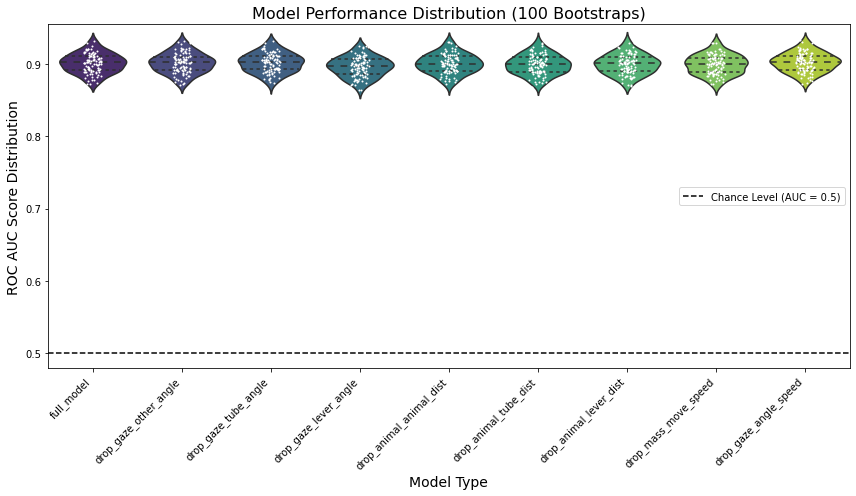

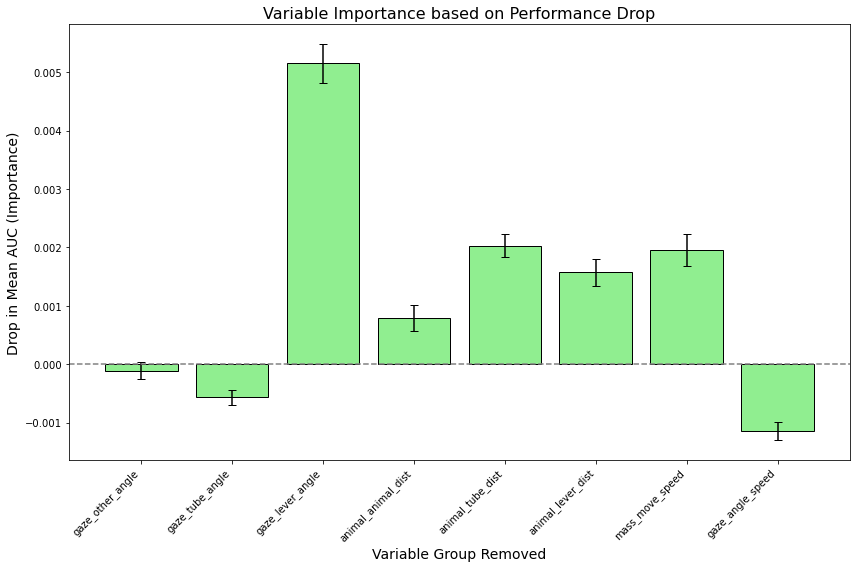

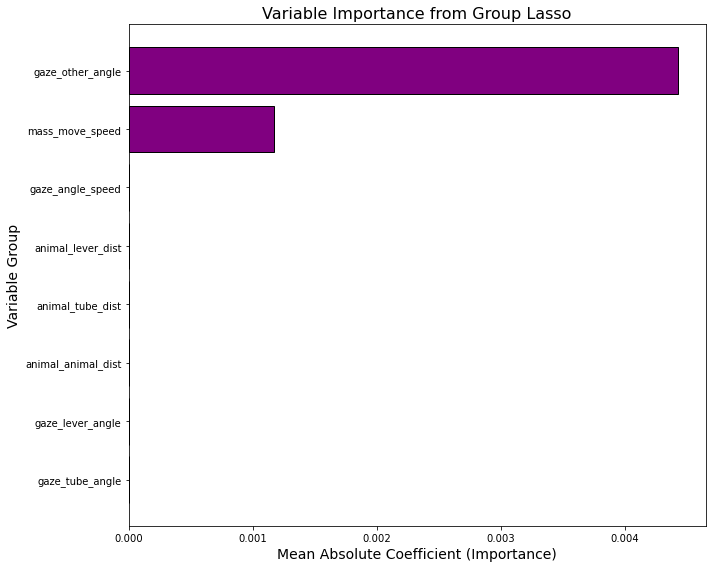

In [39]:
# combine the raw data together across session (in the same or tgt condition) and then run the glm
# the goal is to test which variable contribute the most
if 1:
    
    N_BASIS_FUNCS = 10
    
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score
    from group_lasso import LogisticGroupLasso
    
    
    ind_tgt = np.isin(task_conditions,conditions_to_ana)

    dates_tgt = np.array(dates_list)[ind_tgt]
    ndates = np.shape(dates_tgt)[0]

    # 
    X_all_conbined = []
    Y_all_conbined = []
    
    for idate in np.arange(0,ndates,1):

        date_tgt = dates_tgt[idate]
        
        var_names = pre_data_for_GLM_alldates[date_tgt][(act_animal_to_ana,'var_names')]
        
        X_idate = pre_data_for_GLM_alldates[date_tgt][(act_animal_to_ana,'X_all')]
        Y_idate = pre_data_for_GLM_alldates[date_tgt][(act_animal_to_ana,'Y')]
        
        # Z-score normalize per session
        scaler = StandardScaler()
        X_idate_zscored = scaler.fit_transform(X_idate)

        # Optional: remove nan rows
        valid_rows = ~np.isnan(X_idate_zscored).any(axis=1)
        X_valid = X_idate_zscored[valid_rows]
        Y_valid = Y_idate[valid_rows]

        X_all_conbined.append(X_valid)
        Y_all_conbined.append(Y_valid)
        
    
    X_combined = np.vstack(X_all_conbined)
    Y_combined = np.concatenate(Y_all_conbined)
    
    # ==============================================================================
    # BOOTSTRAP WITH LEAVE-ONE-GROUP-OUT & GROUP LASSO
    # ==============================================================================

    # 1. Setup bootstrap and results storage
    n_bootstraps = 100
    results = {'full_model': []}
    for var in var_names:
        results[f'drop_{var}'] = []

    ## NEW ##
    # Add a list to store the Group Lasso coefficients from each iteration
    lasso_coeffs_all_runs = [] 
    # Define the feature groups once, as it's the same for all iterations
    n_variables = len(var_names)
    groups = np.repeat(np.arange(n_variables), repeats=N_BASIS_FUNCS)


    # 2. Start bootstrap loop
    for i in range(n_bootstraps):
        print(f"🚀 Running bootstrap iteration {i+1}/{n_bootstraps}...")

        # a. Balance dataset for this iteration
        # (Your existing balancing code is here)
        pos_idx = np.where(Y_combined == 1)[0]
        neg_idx = np.where(Y_combined == 0)[0]
        if len(pos_idx) == 0 or len(neg_idx) < len(pos_idx):
            print(f"Warning: Not enough samples for iteration {i+1}. Skipping.")
            continue
        neg_sample_idx = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
        balanced_idx = np.concatenate([pos_idx, neg_sample_idx])
        np.random.shuffle(balanced_idx)
        X_balanced = X_combined[balanced_idx]
        Y_balanced = Y_combined[balanced_idx]

        # b. Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, Y_balanced, test_size=0.2, stratify=Y_balanced
        )

        # c. Normalize features based ONLY on the training set
        scaler = StandardScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)

        # --- Leave-One-Out Analysis (Your existing code) ---
        # NOTE: I've removed `class_weight='balanced'` because you are already manually balancing the data. Using both is redundant.

        # d. Fit and evaluate the FULL model
        clf_full = LogisticRegression(max_iter=1000) 
        clf_full.fit(X_train_norm, y_train)
        y_proba_full = clf_full.predict_proba(X_test_norm)[:, 1]
        auc_full = roc_auc_score(y_test, y_proba_full)
        results['full_model'].append(auc_full)

        # e. Loop through each variable group to perform leave-one-group-out
        for j, var_to_drop in enumerate(var_names):
            start_col = j * N_BASIS_FUNCS
            end_col = start_col + N_BASIS_FUNCS
            cols_to_drop = np.arange(start_col, end_col)
            X_train_loo = np.delete(X_train_norm, cols_to_drop, axis=1)
            X_test_loo = np.delete(X_test_norm, cols_to_drop, axis=1)

            clf_loo = LogisticRegression(max_iter=1000)
            clf_loo.fit(X_train_loo, y_train)
            y_proba_loo = clf_loo.predict_proba(X_test_loo)[:, 1]
            auc_loo = roc_auc_score(y_test, y_proba_loo)
            results[f'drop_{var_to_drop}'].append(auc_loo)

        ## NEW ## 
        # --- Group Lasso Analysis (run on the same data split) ---
        gl_model = LogisticGroupLasso(
            groups=groups,
            group_reg=0.05,  # This is a key parameter to tune
            supress_warning=True
        )
        gl_model.fit(X_train_norm, y_train)
        # Store the resulting coefficients for this iteration
        lasso_coeffs_all_runs.append(gl_model.coef_)


    print("\n✅ Bootstrap analysis complete.")

    # 3. Summarize and Plot the results
    # --- First, analyze and plot the Leave-One-Out results (your existing code) ---
    results_df = pd.DataFrame(results)
    summary_stats = results_df.agg(['mean', 'std']).T
    
    summary_stats.rename(columns={'mean': 'mean_auc', 'std': 'std_auc'}, inplace=True)
    mean_full_auc = summary_stats.loc['full_model', 'mean_auc']
    summary_stats['auc_drop_from_full'] = mean_full_auc - summary_stats['mean_auc']

    print("\n--- 📊 Summary of Model Performance ---")
    print(summary_stats.sort_values(by='auc_drop_from_full', ascending=False))

    # Plotting...
    # (The plotting code from the previous answer can be used here without any changes)
    # --- Plot 1: Mean AUC for each model ---
    print("📊 Generating violin plot of model performance...")
    fig, ax = plt.subplots(figsize=(12, 7))
    # Reshape the DataFrame from wide to long format for Seaborn
    plot_df_long = results_df.melt(var_name='model', value_name='auc')
    # Define the desired order to prevent automatic sorting
    model_order = ['full_model'] + [f'drop_{var}' for var in var_names]
    # Create the violin plot
    sns.violinplot(
        data=plot_df_long, 
        x='model', 
        y='auc', 
        order=model_order, 
        inner='quartile', # Shows the quartiles inside the violins
        palette='viridis',
        ax=ax
    )
    # Overlay individual data points for more detail
    sns.stripplot(
        data=plot_df_long,
        x='model',
        y='auc',
        order=model_order,
        size=2,
        color="white",
        edgecolor='gray',
        ax=ax
    )
    ax.set_ylabel('ROC AUC Score Distribution', fontsize=14)
    ax.set_xlabel('Model Type', fontsize=14)
    ax.set_title(f'Model Performance Distribution ({n_bootstraps} Bootstraps)', fontsize=16)
    ax.axhline(y=0.5, color='black', linestyle='--', label='Chance Level (AUC = 0.5)')
    ax.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # --- Plot 2: Feature importance with error bars ---
    xvarnames_tosort = ['gaze_other_angle','gaze_tube_angle','gaze_lever_angle','animal_animal_dist',
                        'animal_tube_dist','animal_lever_dist','mass_move_speed','gaze_angle_speed']
    #
    # 1. Calculate the AUC drop for each bootstrap run to get a distribution of importance scores.
    auc_drops_df = pd.DataFrame()
    for col in results_df.columns:
        if 'drop_' in col:
            auc_drops_df[col] = results_df['full_model'] - results_df[col]
    # 2. Calculate the mean and standard deviation from these distributions.
    mean_drops = auc_drops_df.mean()
    std_drops = auc_drops_df.std()
    sem_drops = std_drops/np.sqrt(n_bootstraps)
    # 3. Create a new DataFrame for plotting.
    importance_data = pd.DataFrame({
        'mean_drop': mean_drops,
        'std_drop': std_drops,
        'sem_drop': sem_drops,
    })
    #
    # Create a correctly prefixed list for sorting
    sorted_index = ['drop_' + name for name in xvarnames_tosort]
    # Reorder the DataFrame based on your list
    importance_data = importance_data.reindex(sorted_index)
    # 4. Create the plot.
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    # Switched to a vertical bar plot
    ax2.bar(
        importance_data.index.str.replace('drop_', ''),
        importance_data['mean_drop'],
        # Switched to yerr for vertical error bars
        yerr=importance_data['sem_drop'],
        capsize=4, # Adds caps to the error bars
        color='lightgreen',
        edgecolor='black'
    )
    # Swapped axis labels
    ax2.set_ylabel('Drop in Mean AUC (Importance)', fontsize=14)
    ax2.set_xlabel('Variable Group Removed', fontsize=14)
    ax2.set_title('Variable Importance based on Performance Drop', fontsize=16)
    # Switched to a horizontal line
    ax2.axhline(y=0, color='grey', linestyle='--')
    # Added rotation for better label readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    ## NEW ##
    # --- Second, analyze and plot the Group Lasso results ---
    print("\n--- 📊 Summary of Group Lasso Coefficients ---")
    # Average the coefficients across all bootstrap runs
    mean_lasso_coeffs = np.mean(lasso_coeffs_all_runs, axis=0)

    # Calculate the average magnitude of coefficients for each variable group
    group_importance = []
    for i, var_name in enumerate(var_names):
        start_idx = i * N_BASIS_FUNCS
        end_idx = start_idx + N_BASIS_FUNCS
        # Use the absolute mean coefficient magnitude as the importance score
        importance_score = np.mean(np.abs(mean_lasso_coeffs[start_idx:end_idx]))
        group_importance.append({'variable': var_name, 'importance': importance_score})

    # Create a DataFrame for easy sorting and plotting
    lasso_importance_df = pd.DataFrame(group_importance).sort_values('importance', ascending=True)

    print(lasso_importance_df)

    # Plot 3: Group Lasso Feature Importance
    fig3, ax3 = plt.subplots(figsize=(10, 8))
    ax3.barh(
        lasso_importance_df['variable'],
        lasso_importance_df['importance'],
        color='purple',
        edgecolor='black'
    )
    ax3.set_xlabel('Mean Absolute Coefficient (Importance)', fontsize=14)
    ax3.set_ylabel('Variable Group', fontsize=14)
    ax3.set_title('Variable Importance from Group Lasso', fontsize=16)
    plt.tight_layout()
    
    # Save figure
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder + "fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_glm_model/" + \
                        cameraID + "/" + animal1_filenames[0] + "_" + animal2_filenames[0] + "/glm_fitting_summary_fig/"

        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        fig.savefig(figsavefolder + act_animal_to_ana + '_in_' + cond_toplot_type +
                    '_glm_fitting_auc_full_model_and_leave_one_variable_out.pdf')
        
        fig2.savefig(figsavefolder + act_animal_to_ana + '_in_' + cond_toplot_type +
                    '_glm_fitting_drop_in_auc_full_model_and_leave_one_variable_out.pdf')
        
        fig3.savefig(figsavefolder + act_animal_to_ana + '_in_' + cond_toplot_type +
                    '_glm_fitting_group_lasso_full_model_.pdf')

        

/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ws523/.conda/envs/DLC/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


✅ Illustration saved successfully to: glm_method_illustration.pdf


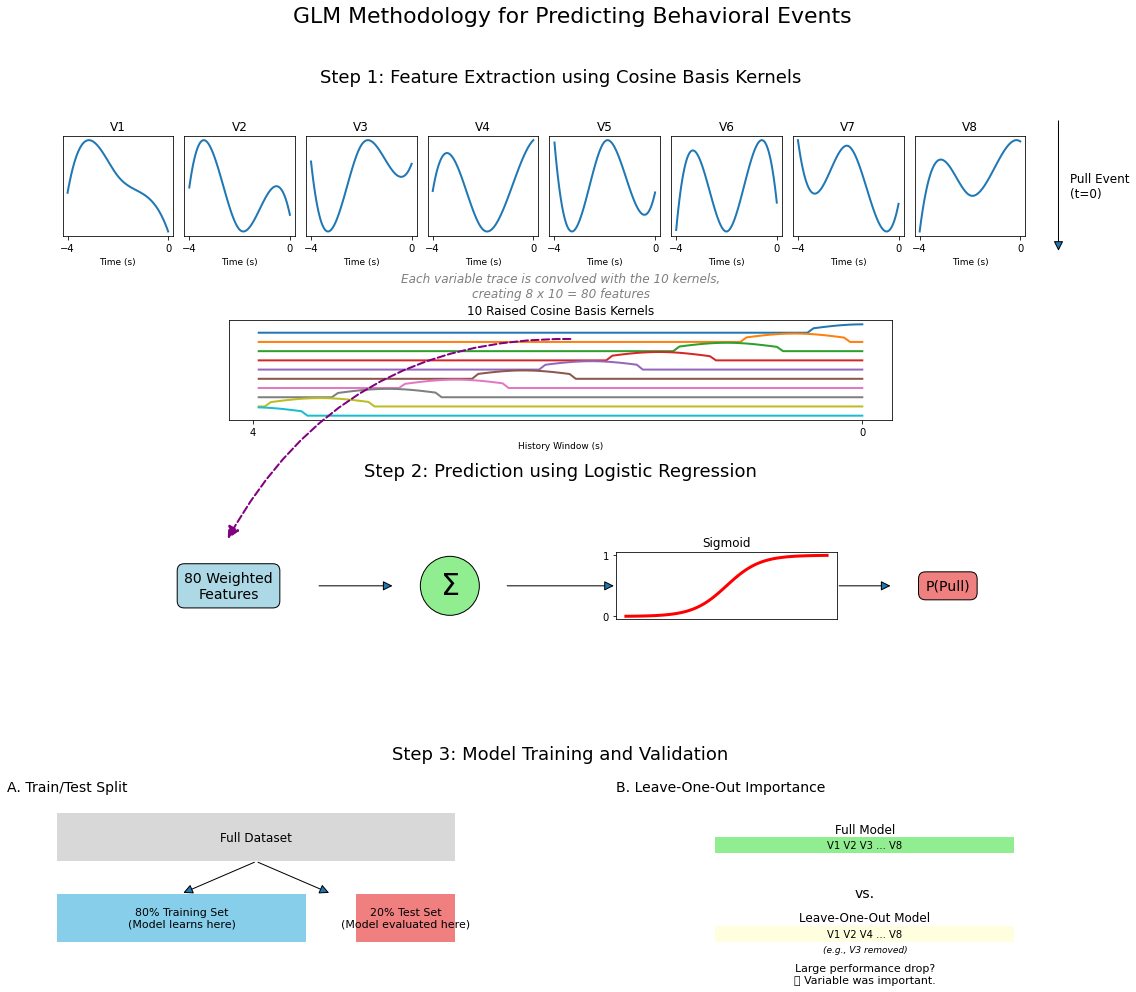

In [24]:
# generate demo glm pipeline cartoon
if 1:
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch, PathPatch, ConnectionStyle, Rectangle
    from matplotlib.path import Path
    from scipy.interpolate import make_interp_spline

    def make_raised_cosine_basis(duration_s, n_basis, dt):
        """
        Generates a basis set of raised cosines.
        """
        t = np.arange(0, duration_s, dt)
        c = np.linspace(0, duration_s, n_basis)
        width = (c[1] - c[0]) * 1.5
        basis = []
        for ci in c:
            phi = (t - ci) * np.pi / width
            b = np.cos(np.clip(phi, -np.pi, np.pi))
            b = (b + 1) / 2
            b[(t < ci - width/2) | (t > ci + width/2)] = 0
            basis.append(b)
        basis = np.stack(basis, axis=1)
        return basis

    def generate_glm_illustration():
        """
        Generates and saves a PDF figure illustrating a GLM methodology, including
        feature extraction, logistic regression, data splitting, and validation procedures.
        """

        # --- 1. Setup Figure and Subplots ---
        # Increased figure height and added a row for the new cartoons
        fig = plt.figure(figsize=(16, 14))
        gs = fig.add_gridspec(3, 1, height_ratios=[1.5, 1, 0.8])
        ax_top = fig.add_subplot(gs[0])
        ax_bottom = fig.add_subplot(gs[1])
        ax_validation = fig.add_subplot(gs[2]) # New axis for validation cartoons

        fig.suptitle("GLM Methodology for Predicting Behavioral Events", fontsize=22, y=0.98)

        # --- 2. Top Row: Feature Extraction ---
        ax_top.set_title("Step 1: Feature Extraction using Cosine Basis Kernels", fontsize=18, pad=20)
        ax_top.axis('off')

        # A. Draw Smoother Variable Traces
        num_vars = 8
        time = np.linspace(-4, 0, 100)
        for i in range(num_vars):
            var_ax = ax_top.inset_axes([0.05 + i*0.11, 0.6, 0.1, 0.3])
            np.random.seed(i)
            spline = make_interp_spline(np.linspace(-4, 0, 5), np.random.rand(5))
            var_ax.plot(time, spline(time), lw=2)
            var_ax.set_title(f"V{i+1}", fontsize=12, pad=5)
            var_ax.set_xticks([-4, 0]); var_ax.set_yticks([]); var_ax.set_xlabel("Time (s)", fontsize=9)

        # B. Draw Kernels using your function
        num_kernels = 10; duration_s = 4; dt = 0.04
        kernel_ax = ax_top.inset_axes([0.2, 0.05, 0.6, 0.3])
        basis_kernels = make_raised_cosine_basis(duration_s, num_kernels, dt)
        for k in range(basis_kernels.shape[1]):
            kernel_ax.plot(np.arange(0, duration_s, dt), basis_kernels[:, k] - k * 1.1, lw=2)
        kernel_ax.set_title("10 Raised Cosine Basis Kernels", fontsize=12)
        kernel_ax.set_yticks([]); kernel_ax.set_xticks([0, 4]); kernel_ax.set_xlabel("History Window (s)", fontsize=9)
        kernel_ax.invert_xaxis()

        # C. Add connecting text and lines
        ax_top.text(0.5, 0.45, "Each variable trace is convolved with the 10 kernels,\ncreating 8 x 10 = 80 features",
                    ha='center', va='center', fontsize=12, style='italic', color='gray')
        pull_line = FancyArrowPatch((0.95, 0.95), (0.95, 0.55), mutation_scale=20, arrowstyle='-|>')
        ax_top.add_patch(pull_line)
        ax_top.text(0.96, 0.75, "Pull Event\n(t=0)", va='center', fontsize=12)

        # --- 3. Middle Row: Logistic Regression Model ---
        ax_bottom.set_title("Step 2: Prediction using Logistic Regression", fontsize=18, pad=20)
        ax_bottom.axis('off')

        # A. Draw model components
        ax_bottom.text(0.2, 0.6, "80 Weighted\nFeatures", ha='center', va='center', fontsize=14,
                       bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", ec="black"))
        ax_bottom.text(0.4, 0.6, "$\\Sigma$", ha='center', va='center', fontsize=30,
                       bbox=dict(boxstyle="circle,pad=0.5", fc="lightgreen", ec="black"))
        sigmoid_ax = ax_bottom.inset_axes([0.55, 0.45, 0.2, 0.3])
        x_sig = np.linspace(-6, 6, 100)
        sigmoid_ax.plot(x_sig, 1 / (1 + np.exp(-x_sig)), color='red', lw=3)
        sigmoid_ax.set_title("Sigmoid", fontsize=12); sigmoid_ax.set_xticks([]); sigmoid_ax.set_yticks([0, 1])
        ax_bottom.text(0.85, 0.6, "P(Pull)", ha='center', va='center', fontsize=14,
                       bbox=dict(boxstyle="round,pad=0.5", fc="lightcoral", ec="black"))

        # B. Add arrows
        ax_bottom.add_patch(FancyArrowPatch((0.28, 0.6), (0.35, 0.6), mutation_scale=20, arrowstyle='-|>'))
        ax_bottom.add_patch(FancyArrowPatch((0.45, 0.6), (0.55, 0.6), mutation_scale=20, arrowstyle='-|>'))
        ax_bottom.add_patch(FancyArrowPatch((0.75, 0.6), (0.8, 0.6), mutation_scale=20, arrowstyle='-|>'))

        # --- 4. Connect Top and Bottom Rows ---
        con = ConnectionStyle.Arc3(rad=0.3)
        arrow = FancyArrowPatch((0.5, 0.65), (0.2, 0.45), transform=fig.transFigure, connectionstyle=con,
                                arrowstyle="-|>", mutation_scale=25, lw=2, color='purple', linestyle='dashed')
        fig.add_artist(arrow)

        # --- 5. NEW: Bottom Row for Validation Cartoons ---
        ax_validation.set_title("Step 3: Model Training and Validation", fontsize=18, pad=20)
        ax_validation.axis('off')

        # A. Cartoon for 80/20 Split
        ax_split = ax_validation.inset_axes([0, 0, 0.45, 0.9])
        ax_split.set_title("A. Train/Test Split", fontsize=14, loc='left')
        ax_split.axis('off')
        ax_split.add_patch(Rectangle((0.1, 0.6), 0.8, 0.3, facecolor='gray', alpha=0.3, label='Full Dataset'))
        ax_split.text(0.5, 0.75, "Full Dataset", ha='center', va='center', fontsize=12)
        ax_split.add_patch(FancyArrowPatch((0.5, 0.6), (0.35, 0.4), mutation_scale=20, arrowstyle='-|>'))
        ax_split.add_patch(FancyArrowPatch((0.5, 0.6), (0.65, 0.4), mutation_scale=20, arrowstyle='-|>'))
        ax_split.add_patch(Rectangle((0.1, 0.1), 0.5, 0.3, facecolor='skyblue', label='Training Set'))
        ax_split.text(0.35, 0.25, "80% Training Set\n(Model learns here)", ha='center', va='center', fontsize=11)
        ax_split.add_patch(Rectangle((0.7, 0.1), 0.2, 0.3, facecolor='lightcoral', label='Testing Set'))
        ax_split.text(0.8, 0.25, "20% Test Set\n(Model evaluated here)", ha='center', va='center', fontsize=11)

        # B. Cartoon for Leave-One-Out
        ax_loo = ax_validation.inset_axes([0.55, 0, 0.45, 0.9])
        ax_loo.set_title("B. Leave-One-Out Importance", fontsize=14, loc='left')
        ax_loo.axis('off')
        # Full Model
        ax_loo.text(0.5, 0.8, "Full Model", ha='center', va='center', fontsize=12)
        ax_loo.add_patch(Rectangle((0.2, 0.65), 0.6, 0.1, facecolor='lightgreen'))
        ax_loo.text(0.5, 0.7, "V1 V2 V3 ... V8", ha='center', va='center', fontsize=10)
        # Leave-One-Out Model
        ax_loo.text(0.5, 0.4, "vs.", ha='center', va='center', fontsize=14)
        ax_loo.text(0.5, 0.25, "Leave-One-Out Model", ha='center', va='center', fontsize=12)
        ax_loo.add_patch(Rectangle((0.2, 0.1), 0.6, 0.1, facecolor='lightyellow'))
        ax_loo.text(0.5, 0.15, "V1 V2 V4 ... V8", ha='center', va='center', fontsize=10)
        ax_loo.text(0.5, 0.05, "(e.g., V3 removed)", ha='center', va='center', fontsize=9, style='italic')
        ax_loo.text(0.5, -0.1, "Large performance drop?\n Variable was important.", ha='center', va='center', fontsize=11)

        # --- 6. Save the Figure ---
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        file_path = "glm_method_illustration.pdf"
        plt.savefig(file_path)
        print(f"✅ Illustration saved successfully to: {file_path}")

    if __name__ == '__main__':
        generate_glm_illustration()



## old code, not in use for now

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Helper function to define successful pulls
def get_successful_pull_indices(juice_ts, pull_ts):
    juice_indices = np.where(juice_ts == 1)[0]
    pull_indices = np.where(pull_ts == 1)[0]
    if len(juice_indices) == 0 or len(pull_indices) == 0: return np.array([], dtype=int)
    insertion_points = np.searchsorted(pull_indices, juice_indices)
    valid_mask = insertion_points > 0
    successful_indices = pull_indices[insertion_points[valid_mask] - 1]
    return np.unique(successful_indices)

# Helper function to create basis functions
def create_raised_cosine_basis(kernel_len_frames, n_bases):
    x = np.linspace(0, np.pi, kernel_len_frames)
    centers = np.linspace(np.pi / (2 * n_bases), np.pi - np.pi / (2 * n_bases), n_bases)
    width = np.pi / n_bases
    basis_funcs = np.zeros((kernel_len_frames, n_bases))
    for i, center in enumerate(centers):
        mask = (x > center - width) & (x < center + width)
        basis_funcs[mask, i] = (np.cos((x[mask] - center) * np.pi / width) + 1) / 2
    return basis_funcs

# --- Function 1: Prepare the Design Matrix ---
# --- Function 1: Prepare the Design Matrix ---
def prepare_glm_design_matrix(animal_id, self_pull_ts, self_juice_ts, self_speed_ts, self_gaze_ts,
                              partner_pull_ts, partner_speed_ts, fs,
                              kernel_duration_s, n_basis_funcs):
    """
    Prepares the design matrix for a GLM analysis for a single animal.
    MODIFICATION: Replaced partner pull kernel with time since last pull for both self and partner.
    """
    print(f"\n{'='*20} Preparing Design Matrix for {animal_id} {'='*20}")
    
    n_total_frames = len(self_pull_ts)
    kernel_n_frames = int(kernel_duration_s * fs)

    # 1. Pre-computation
    successful_self_pull_indices = get_successful_pull_indices(self_juice_ts, self_pull_ts)
    basis_functions = create_raised_cosine_basis(kernel_n_frames, n_basis_funcs)
    
    # MODIFICATION: Get all pull indices for recency calculation
    all_self_pull_indices = np.where(self_pull_ts == 1)[0]
    all_partner_pull_indices = np.where(partner_pull_ts == 1)[0]

    # 2. Build the Design Matrix using efficient, vectorized operations
    print(f"Building GLM Design Matrix for {animal_id}...")
    
    # Create the main time vector for the analysis
    time_vector = np.arange(n_total_frames)
    
    # a) Vectorized "time since last event" calculations
    def time_since_last_event(event_indices, time_vector):
        if len(event_indices) == 0:
            return np.full(len(time_vector), np.nan)
        insertion_points = np.searchsorted(event_indices, time_vector)
        valid_mask = insertion_points > 0
        last_event_indices = event_indices[insertion_points[valid_mask] - 1]
        time_since = np.full(len(time_vector), np.nan)
        time_since[valid_mask] = (time_vector[valid_mask] - last_event_indices) / fs
        return time_since

    time_since_last_success = time_since_last_event(successful_self_pull_indices, time_vector)
    time_since_last_self_pull = time_since_last_event(all_self_pull_indices, time_vector)
    time_since_last_partner_pull = time_since_last_event(all_partner_pull_indices, time_vector)

    # b) Create the convolved (kernel-based) predictors
    flipped_basis = np.ascontiguousarray(basis_functions[::-1, :])
    convolved_features = {}
    for i in range(n_basis_funcs):
        basis = flipped_basis[:, i]
        convolved_features[f'self_speed_b{i}'] = np.convolve(self_speed_ts, basis, mode='same')
        convolved_features[f'partner_speed_b{i}'] = np.convolve(partner_speed_ts, basis, mode='same')

    # b) Create the simple average (rolling mean) predictor for GAZE
    gaze_mean = pd.Series(self_gaze_ts).rolling(window=kernel_n_frames).mean().to_numpy()
    
    # c) Assemble the final DataFrame
    design_matrix = pd.DataFrame(convolved_features)
    design_matrix['time_since_last_success'] = time_since_last_success
    design_matrix['time_since_last_self_pull'] = time_since_last_self_pull
    design_matrix['time_since_last_partner_pull'] = time_since_last_partner_pull
    design_matrix['response'] = self_pull_ts
    design_matrix['self_gaze_auc'] = gaze_mean # Add the simple average predictor
    
    # Drop rows with NaN (from the beginning before the first events occurred) and reset index
    design_matrix = design_matrix.dropna().reset_index(drop=True)
    print(f"Design matrix for {animal_id} created with {len(design_matrix)} rows.")
    
    return design_matrix

# --- Function 2: Fit the GLM and Return Results ---
def fit_and_summarize_glm(design_matrix, animal_id):
    """
    Fits a logistic GLM to a pre-prepared design matrix.
    """
    print(f"\n--- Fitting Logistic GLM for {animal_id} ---")
    if design_matrix is None or design_matrix.empty:
        print(f"Cannot fit model for {animal_id}, design matrix is empty.")
        return None
        
    y = design_matrix['response']
    X = design_matrix.drop(columns=['response','self_gaze_auc'])
    X = sm.add_constant(X, prepend=True) # Ensure const is the first column    

    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=0)
    
    return result, X


# --- Function 3: kernel recontruction ---
# --- 3. MODIFICATION: New function to reconstruct and plot from the results object ---
def reconstruct_and_plot_kernel(ax, glm_results, variable_name, basis_funcs, color, label):
    """
    Reconstructs and plots a single kernel with its 95% CI from a fitted GLM results object.
    
    Args:
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        glm_results (statsmodels.results.ResultWrapper): The fitted model object.
        variable_name (str): The base name of the variable (e.g., 'self_speed').
        basis_funcs (np.array): The basis function matrix used for fitting.
        color (str): The color for the plot line.
        label (str): The label for the plot legend.
    """
    n_bases = basis_funcs.shape[1]
    
    # Automatically find all coefficients related to the variable (e.g., 'self_speed_b0', 'self_speed_b1', ...)
    coef_names = [f'{variable_name}_b{i}' for i in range(n_bases)]
    
    # Extract coefficients and the relevant part of the covariance matrix
    try:
        coeffs = glm_results.params.filter(items=coef_names)
        cov_matrix = glm_results.cov_params().loc[coef_names, coef_names]
    except KeyError:
        print(f"Warning: Could not find coefficients for '{variable_name}' in the model results. Skipping.")
        return

    # Reconstruct the kernel by multiplying the basis functions by their fitted weights
    reconstructed_kernel = basis_funcs @ coeffs
    
    # --- Calculate the 95% Confidence Interval for the kernel ---
    # This involves matrix multiplication with the covariance matrix
    kernel_variance = np.diag(basis_funcs @ cov_matrix @ basis_funcs.T)
    kernel_std_err = np.sqrt(kernel_variance)
    
    upper_ci = reconstructed_kernel + 1.96 * kernel_std_err
    lower_ci = reconstructed_kernel - 1.96 * kernel_std_err
    
    # --- Plotting ---
    time_axis = np.linspace(-KERNEL_DURATION_S, 0, len(reconstructed_kernel))
    ax.plot(time_axis, reconstructed_kernel, color=color, label=label, linewidth=2.5)
    ax.fill_between(time_axis, lower_ci, upper_ci, color=color, alpha=0.2, label=f'_nolegend_')


# 
# --- 2. Define a Reusable Function to Calculate the Partial Decision Variable ---
def add_partial_decision_variable(glm_results, design_matrix, variable_base_name, new_column_name):
    """
    Calculates a decision variable using only the intercept and one set of kernel coefficients.

    Args:
        glm_results (statsmodels.results.ResultWrapper): The fitted model object.
        design_matrix (pd.DataFrame): The design matrix used for fitting.
        variable_base_name (str): The base name of the variable (e.g., 'partner_speed').
        new_column_name (str): The name for the new column to be added.
    """
    if glm_results is None or design_matrix.empty:
        print(f"Skipping calculation for {new_column_name}, model or data is empty.")
        return design_matrix
    
    # a) Get all fitted parameters from the results object
    all_params = glm_results.params

    # b) Isolate the specific coefficients we need
    coef_names = [f'{variable_base_name}_b{i}' for i in range(N_BASIS_FUNCS)]
    variable_coeffs = all_params.filter(items=coef_names)
    intercept_coef = all_params['const']

    # c) Select the corresponding feature columns from the design matrix
    variable_features = design_matrix[coef_names]

    # d) Calculate the weighted sum (dot product) and add the intercept
    partial_dv = variable_features.dot(variable_coeffs) + intercept_coef
    
    # e) Add the result as a new column to the original dataframe
    design_matrix[new_column_name] = partial_dv
    
    print(f"Added column '{new_column_name}' to the dataframe.")
    return design_matrix

In [ ]:

# --- Main Execution ---

# MODIFICATION: Define kernel parameters here for easy adjustment
KERNEL_DURATION_S = 4.0  # The length of the history kernel in seconds
N_BASIS_FUNCS = 8        # The number of basis functions to represent the kernel

# STEP A: Prepare the data for each animal, passing the new parameters
design_matrix_a1 = prepare_glm_design_matrix(
    animal_id='animal1',
    self_pull_ts=pull1_data, self_juice_ts=juice1_data, self_speed_ts=speed1_data, self_gaze_ts=gaze1_data,
    partner_pull_ts=pull2_data, partner_speed_ts=speed2_data, fs=fps,
    kernel_duration_s=KERNEL_DURATION_S, n_basis_funcs=N_BASIS_FUNCS
)

design_matrix_a2 = prepare_glm_design_matrix(
    animal_id='animal2',
    self_pull_ts=pull2_data, self_juice_ts=juice2_data, self_speed_ts=speed2_data, self_gaze_ts=gaze2_data,
    partner_pull_ts=pull1_data, partner_speed_ts=speed1_data, fs=fps,
    kernel_duration_s=KERNEL_DURATION_S, n_basis_funcs=N_BASIS_FUNCS
)


In [ ]:
kernel_duration_s = KERNEL_DURATION_S
n_bases = N_BASIS_FUNCS
kernel_n_frames = int(kernel_duration_s * fps)
basis_functions = create_raised_cosine_basis(kernel_n_frames, n_bases)

In [ ]:
design_matrix_a1['time_since_last_partner_pull']

In [ ]:
# STEP B: Fit the models
glm_results_a1, X1 = fit_and_summarize_glm(design_matrix_a1, 'animal1')
glm_results_a2, X2 = fit_and_summarize_glm(design_matrix_a2, 'animal2')


# --- MODIFICATION: Add new step to reconstruct the decision variable ---
print("\n" + "="*50)
print("              RECONSTRUCTING DECISION VARIABLE")
print("="*50)

if glm_results_a1 is not None:
    # Use the .predict() method on the fitted model with the original data
    # This returns the linear predictor (log-odds) for each time step
    decision_variable_a1 = glm_results_a1.predict(X1)
    
    # Add it as a new column to the original design matrix
    design_matrix_a1['decision_variable'] = decision_variable_a1
    
    print("\n--- Animal 1 Design Matrix with new 'decision_variable' column ---")
    print(design_matrix_a1[['response', 'decision_variable']].head())

if glm_results_a2 is not None:
    decision_variable_a2 = glm_results_a2.predict(X2)
    design_matrix_a2['decision_variable'] = decision_variable_a2
    
    print("\n--- Animal 2 Design Matrix with new 'decision_variable' column ---")
    print(design_matrix_a2[['response', 'decision_variable']].head())

print("\nReconstruction complete. The design matrices have been updated.")


# STEP C: Inspect the final results
print("\n\n" + "="*50)
print("              FINAL GLM RESULTS")
print("="*50)
if glm_results_a1:
    print("\n\n--- GLM Fit Summary for Animal 1 ---")
    print(glm_results_a1.summary())
if glm_results_a2:
    print("\n\n--- GLM Fit Summary for Animal 2 ---")
    print(glm_results_a2.summary())

In [ ]:

# Create a figure with two subplots, side-by-side
print("\n--- Plotting Reconstructed Kernels directly from model results ---")
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# --- Plot for Animal 1 ---
ax1 = axes[0]
reconstruct_and_plot_kernel(ax1, glm_results_a1, 'self_speed', basis_functions, 'blue', 'Self Speed Kernel')
reconstruct_and_plot_kernel(ax1, glm_results_a1, 'partner_speed', basis_functions, 'green', 'Partner Speed Kernel')
# You could also plot the partner_pull kernel here
# reconstruct_and_plot_kernel(ax1, glm_results_a1, 'partner_pull', basis_functions, 'purple', 'Partner Pull Kernel')

ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set_title('Animal 1: Reconstructed Kernels', fontsize=16)
ax1.set_xlabel('Time before Pull (seconds)', fontsize=12)
ax1.set_ylabel('Kernel Weight (Influence on Pulling)', fontsize=12)
ax1.legend()


# --- Plot for Animal 2 ---
ax2 = axes[1]
reconstruct_and_plot_kernel(ax2, glm_results_a2, 'self_speed', basis_functions, 'blue', 'Self Speed Kernel')
reconstruct_and_plot_kernel(ax2, glm_results_a2, 'partner_speed', basis_functions, 'green', 'Partner Speed Kernel')

ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_title('Animal 2: Reconstructed Kernels', fontsize=16)
ax2.set_xlabel('Time before Pull (seconds)', fontsize=12)
ax2.legend()

plt.suptitle('Comparison of GLM Kernels Across Animals (with 95% C.I.)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
plt.plot(design_matrix_a2['response'][100:500])
plt.plot(design_matrix_a2['decision_variable'][100:500])



In [ ]:
ind_ = design_matrix_a2['response']==1
design_matrix_tgt = design_matrix_a2[ind_]

x = design_matrix_tgt['decision_variable']
y = design_matrix_tgt['self_gaze_auc']

plt.plot(design_matrix_tgt['decision_variable'],design_matrix_tgt['self_gaze_auc'],'.')

# 1. Perform the linear regression to get all statistics
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
print(slope)
print(r_value)
print(p_value)


In [ ]:
# --- 3. Main Execution: Add the new column for each animal ---
print("\n--- Reconstructing partial decision variable for Partner Speed ---")

# For Animal 1
design_matrix_a1 = add_partial_decision_variable(
    glm_results=glm_results_a1,
    design_matrix=design_matrix_a1,
    variable_base_name='partner_speed',
    new_column_name='decision_variable_partner_speed'
)

# For Animal 2
design_matrix_a2 = add_partial_decision_variable(
    glm_results=glm_results_a2,
    design_matrix=design_matrix_a2,
    variable_base_name='partner_speed',
    new_column_name='decision_variable_partner_speed'
)

In [ ]:
plt.plot(design_matrix_a2['time_since_last_success'])

In [ ]:
plt.plot(design_matrix_a2['response'][100:1000])
plt.plot(design_matrix_a2['decision_variable_partner_speed'][100:1000])


In [ ]:
ind_ = design_matrix_a2['response']==1
design_matrix_tgt = design_matrix_a2[ind_]

x = design_matrix_tgt['decision_variable_partner_speed']
y = design_matrix_tgt['self_gaze_auc']

plt.plot(design_matrix_tgt['decision_variable_partner_speed'],design_matrix_tgt['self_gaze_auc'],'.')

# 1. Perform the linear regression to get all statistics
slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
print(slope)
print(r_value)
print(p_value)
